In [13]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
import gc
import re
import shutil
import time
import json
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Bidirectional, LSTM, Dense, Masking
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [3]:
asl_df = pd.read_csv(r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\30videodataset (1).csv")
display(asl_df)

,Video file,Gloss
0,14154575310664197-NICE.mp4,NICE
1,18199086230023087-NICE.mp4,NICE
2,3597949009905055-NICE.mp4,NICE
3,8565239257906878-NICE.mp4,NICE
4,2575780253377702-NICE.mp4,NICE
...,...,...
354,22369668985632774-YOUR.mp4,YOUR
355,32521170014807677-YOUR.mp4,YOUR
356,8184724937356351-YOUR.mp4,YOUR
357,217732808571379-YOUR.mp4,YOUR


In [4]:
asl_df.shape

(359, 2)

In [5]:
selected_glosses = np.array(asl_df["Gloss"].unique())
selected_glosses

array(['NICE', 'THANKYOU', 'MEET', 'FINE1', 'HOW1', 'WHAT1', 'COOL4',
       'NAME', 'HELLO', 'YOU', 'ME', 'YOUR'], dtype=object)

In [8]:
def clean_gloss(gloss):
    return re.sub(r'\d+', '', gloss).lower().strip()

# Apply the function to the 'Gloss' column
asl_df["Gloss"] = asl_df["Gloss"].apply(clean_gloss)

In [9]:
selected_glosses = np.array(asl_df["Gloss"].unique())
selected_glosses

array(['nice', 'thankyou', 'meet', 'fine', 'how', 'what', 'cool', 'name',
       'hello', 'you', 'me', 'your'], dtype=object)

In [10]:
label_map = {label:num for num, label in enumerate(selected_glosses)}

In [11]:
label_map

{'nice': 0,
 'thankyou': 1,
 'meet': 2,
 'fine': 3,
 'how': 4,
 'what': 5,
 'cool': 6,
 'name': 7,
 'hello': 8,
 'you': 9,
 'me': 10,
 'your': 11}

In [14]:
DATA_PATH = os.path.join(r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30")

In [15]:
sequence_length = 30
sequences, labels = [], []
for gloss in selected_glosses:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, gloss))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, gloss, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[gloss])

In [16]:
X = np.array(sequences)

In [17]:
X

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.60422903e-01,  6.84300959e-01, -8.16112533e-02],
        [ 5.36895871e-01,  9.03232217e-01,  4.98772977e-07, ...,
          5.00927031e-01,  6.63364410e-01, -8.77217501e-02],
        [ 4.97712970e-01,  8.46662998e-01,  3.40641975e-07, ...,
          5.35936713e-01,  6.51133657e-01, -9.45451036e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          3.82566333e-01,  8.54407668e-01, -9.48076621e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.24449235e-01,  9.70091581e-01, -1.47450879e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.59606677e-01,  6.89421654e

In [18]:
X.shape

(3231, 30, 126)

In [19]:
#y_labels.shape
np.array(labels).shape

(3231,)

In [20]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [22]:
y.shape

(3231, 12)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=34, stratify=y)

In [24]:
y_test.shape

(162, 12)

In [25]:
y_train.shape

(3069, 12)

In [30]:
from keras import models, layers
from keras.layers import GRU, Dense, Dropout, BatchNormalization, Masking, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam

In [31]:
model = models.Sequential()
model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Masking(mask_value=0.0))

# 1st GRU Layer
model.add(GRU(64, return_sequences=True, activation=None, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(negative_slope=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Increased dropout to reduce overfitting

# 2nd GRU Layer
model.add(GRU(64, activation=None, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(negative_slope=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense Layers
model.add(Dense(64, kernel_regularizer=l2(0.001)))  # More capacity before classification
model.add(LeakyReLU(negative_slope=0.1))
model.add(Dropout(0.3))

model.add(Dense(selected_glosses.shape[0], activation='softmax'))  # Output layer


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 30, 126)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 30, 64)         │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,276 (262.80 KB)

 Trainable params: 67,020 (261.80 KB)

 Non-trainable params: 256 (1.00 KB)

In [33]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [34]:
model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test))

Epoch 1/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - categorical_accuracy: 0.1065 - loss: 3.3242 - val_categorical_accuracy: 0.1914 - val_loss: 2.7365
Epoch 2/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - categorical_accuracy: 0.2050 - loss: 2.7083 - val_categorical_accuracy: 0.2469 - val_loss: 2.5990
Epoch 3/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - categorical_accuracy: 0.2755 - loss: 2.4445 - val_categorical_accuracy: 0.3580 - val_loss: 2.4036
Epoch 4/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.3469 - loss: 2.2438 - val_categorical_accuracy: 0.5309 - val_loss: 2.1393
Epoch 5/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.4239 - loss: 1.9981 - val_categorical_accuracy: 0.6420 - val_loss: 1.8420
Epoch 6/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.4818 - loss: 1.8708 - val_categorical_accuracy: 0.6852 - val_loss: 1.6028
Epoch 7/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.540

KeyboardInterrupt: 

In [35]:
training_res = model.predict(X_train)
print(model.evaluate(X_train, y_train))

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.9959 - loss: 0.1654
[0.1664012223482132, 0.9960899353027344]


In [36]:
#evaluate the model on the test set
res = model.predict(X_test)
print(model.evaluate(X_test, y_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.9779 - loss: 0.2190
[0.21884529292583466, 0.9814814925193787]


In [ ]:
model.save('GRU_model.h5')

In [38]:
del model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('GRU_model.h5') 

In [40]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [42]:
ypred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [43]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [44]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[149,   0],
        [  0,  13]],

       [[147,   1],
        [  0,  14]],

       [[149,   0],
        [  0,  13]],

       [[147,   2],
        [  0,  13]],

       [[149,   0],
        [  0,  13]],

       [[148,   0],
        [  0,  14]],

       [[148,   0],
        [  0,  14]],

       [[148,   0],
        [  0,  14]],

       [[148,   0],
        [  0,  14]],

       [[149,   0],
        [  0,  13]],

       [[148,   0],
        [  1,  13]],

       [[149,   0],
        [  2,  11]]], dtype=int64)

<Figure size 800x600 with 0 Axes>

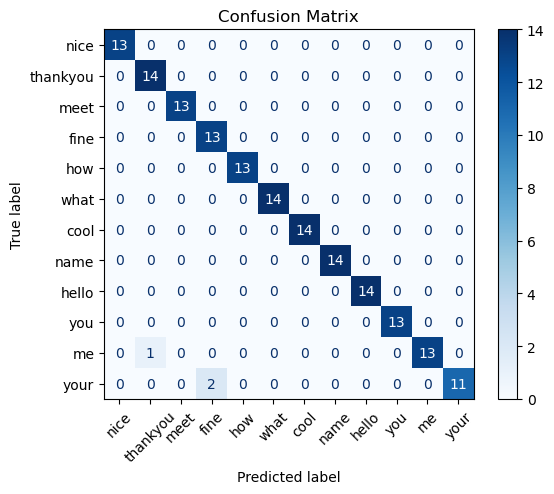

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ytrue, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_glosses)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [46]:
from sklearn.metrics import classification_report

print(classification_report(ytrue, ypred, target_names=selected_glosses))

              precision    recall  f1-score   support

        nice       1.00      1.00      1.00        13
    thankyou       0.93      1.00      0.97        14
        meet       1.00      1.00      1.00        13
        fine       0.87      1.00      0.93        13
         how       1.00      1.00      1.00        13
        what       1.00      1.00      1.00        14
        cool       1.00      1.00      1.00        14
        name       1.00      1.00      1.00        14
       hello       1.00      1.00      1.00        14
         you       1.00      1.00      1.00        13
          me       1.00      0.93      0.96        14
        your       1.00      0.85      0.92        13

    accuracy                           0.98       162
   macro avg       0.98      0.98      0.98       162
weighted avg       0.98      0.98      0.98       162

